##### Описание:
Классифицировать игроков в каждом кадре по двум командам на основе цвета их формы.

### Данные:
Скачайте архив с данными [отсюда](https://disk.yandex.ru/d/NMlVHytktlzbEw) и распакуйте. Внутри архива лежит папка `frames` и файл `bboxes.json`. Файл `bboxes.json` содержит bounding boxes игроков двух команд, а в папке `frames` расположены соответствующие им изображения (кадры). Всего дано 100 кадров. Каждому кадру соответствует 10 bounding boxes игроков.

Структура файла `bboxes.json` следующая:
```
frame_n: {
     player_1: {
             'box': [x,y,w,h],
             'team': int
     }
     .....
     plyaer_10: { .... }
}
....
frame_n+k: { .... }
```
Здесь `frame_n` - номер кадра (ему соответствует файл с изображением в папке frames, всего 100),<br>
`player_1` - id игрока в текущем кадре,<br>
`'box': [x,y,w,h]` - bounding box соответствующего игрока (координаты нормализованы от 0 до 1, поэтому их нужно домножить на размеры изображения, чтобы перевести их в целые координаты фрейма),<br>
`'team': int` - id команды к которой принадлежит игрок  в данном кадре (может принимать значения 0 или 1).
Такм образом, id игроков и id команд имеют смысл только в пределах одного кадра и не связаны с другими кадрами. Т.е. в разных кадрах одному и тому же игроку / команде может соответствовать разные id.

### Задачи:
1) Классифицируйте игроков, используя в качестве вектора признаков игрока (features) средний цвет в пространстве RGB, который берется из области изображения, покрытой bounding box этого игрока (т.е. вектор признаков будет состоять из 3 элементов `[r,g,b]`.<br>
2) Используйте в качестве вектора признаков игроков их средний цвет в пространстве HSV (аналогично вектор признаков `[h,s,v]`.<br>
3) Используйте в качестве вектора признаков гистограмму в пространстве RGB, а не средний цвет. Число бинов определите самостоятельно.<br>
4) Используйте в качестве вектора признаков гистограмму в пространстве HSV.

### Как классифицировать:
В качестве классификатора можете использовать:
- Методы без обучения: k-means (на 2 кластера) или другие методы кластеризации.
- Методы с обучением: K-Nearest Neighbors, RandomForest, GaussianNB или др.

### Результаты:
1. Посчитайте точность классификации для каждого варианта и сравните результаты. 
2. Задание будет принято, если итоговая точность будет выше чем 0.5
3. [опционально] При тестировании на закрытой выборке в конце курса будет подведен итог (рекорд по всем курсам на данный момент - ***0.953***).

#### Полезные советы
- Боксы игроков имеют разный размер, поэтому нормализуйте гистограмму перед ее использованием в качестве вектора признаков (делите значения гистограммы на площадь бокса). 
- Большое число бинов гистограммы может привести к худшим результатам, поэтому попробуйте использовать 8/16/32.
- Для построения вектора признаков лучше использовать некоторую его центральную область, т.к. она покрывает игрока, а границы часто содержут фон / других игроков.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster as sk
import cv2
import json
import os

## Задача №1

### Обявление функция

In [10]:
# Распарсить json-файла
def parsing_json(json_file):
    # Загрузил json
    with open(json_file, 'r') as file:
        data = json.load(file)

        # Перевод в int номер кадра и номер игрока
        data = {
            int(frame_id): {
                int(player_id): info
                for player_id, info in player_id.items()
            }
        for frame_id, player_id in data.items()
        }

        # Перевод bounding_box в [x_min, y_min, w, h]
        for frame_id in data:
            for player_id in data[frame_id]:
                frame = cv2.imread(f'team_classification_data/frames/{frame_id}.jpeg',-1)
                
                x = data[frame_id][player_id]['box'][0] * frame.shape[1]
                y = data[frame_id][player_id]['box'][1] * frame.shape[0]
                w = data[frame_id][player_id]['box'][2] * frame.shape[1]
                h = data[frame_id][player_id]['box'][3] * frame.shape[0]

                data[frame_id][player_id]['box'][0] = int(round(x))
                data[frame_id][player_id]['box'][1] = int(round(y))
                data[frame_id][player_id]['box'][2] = int(round(w))
                data[frame_id][player_id]['box'][3] = int(round(h))
    return data

def get_faverage_color_rgb(x_min,y_min, x_max, y_max, img):
    # Вырезаем область
    img = img[y_min:y_max, x_min:x_max]

    # Перевод в RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Разделение на каналы
    r, g, b = cv2.split(img)

    # Расчет средних значений
    avg_r = np.mean(r)
    avg_g = np.mean(g)
    avg_b = np.mean(b)

    avg_color = [avg_r, avg_g, avg_b]
    return avg_color

def compare(vec, gt):
    res = [1 if g in vec else 0 for g in gt]
    return res

    # GT:
    gt_team1 = [0, 1, 2, 3, 5, 6, 7, 8]
    gt_team2 = [4, 9]

    # Predictions:
    team1 = [0, 2, 3, 5, 6]
    team2 = [1, 4, 7, 8, 9]

    # Calculate accuracy:
    res1 = compare(team1, gt_team1)
    res2 = compare(team2, gt_team2)
    accuracy = sum(res1+res2) / len(gt_team1+gt_team2)
    if accuracy < 0.5:
        res1 = compare(team1, gt_team2)
        res2 = compare(team2, gt_team1)
        accuracy = sum(res1+res2) / len(gt_team1+gt_team2)

    print(res1, res2, 'accuracy:', accuracy)

In [13]:
data = parsing_json('team_classification_data/bboxes.json')

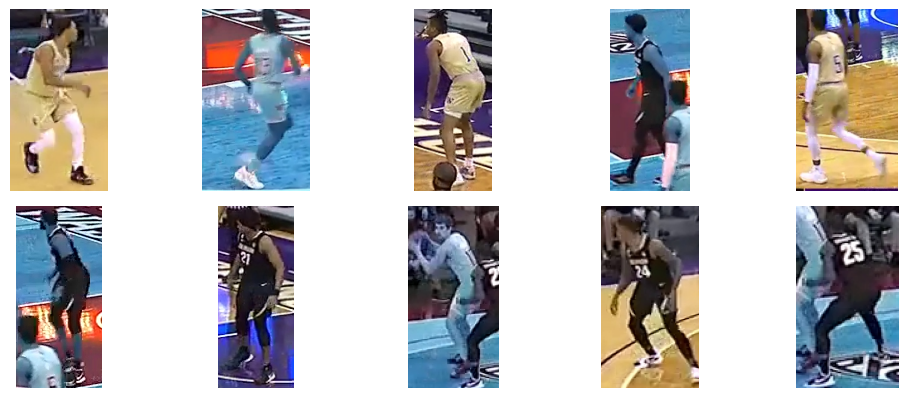

Игрок 1: Реальная команда 0, Предсказанная команда 1
Игрок 2: Реальная команда 0, Предсказанная команда 1
Игрок 3: Реальная команда 0, Предсказанная команда 0
Игрок 4: Реальная команда 1, Предсказанная команда 0
Игрок 5: Реальная команда 0, Предсказанная команда 1
Игрок 6: Реальная команда 1, Предсказанная команда 0
Игрок 7: Реальная команда 1, Предсказанная команда 0
Игрок 8: Реальная команда 0, Предсказанная команда 0
Игрок 9: Реальная команда 0, Предсказанная команда 0
Игрок 10: Реальная команда 1, Предсказанная команда 0
30


In [ ]:
color = (255,0,0)
thickness = 2
frame = 1310
img = cv2.imread(f'team_classification_data/frames/{frame}.jpeg',-1)
features = [] 
gt = []
plt.figure(figsize=(10,10))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for player_id in data[frame]:
    x_min = data[frame][player_id]['box'][0]
    y_min = data[frame][player_id]['box'][1]
    x_max = x_min + data[frame][player_id]['box'][2]
    y_max = y_min + data[frame][player_id]['box'][3]

    img_bbox = img[y_min:y_max, x_min:x_max]
    plt.subplot(5, 5, player_id+1)
    plt.imshow(img_bbox)
    plt.axis('off')

    gt.append(data[frame][player_id]['team'])
    features.append(get_faverage_color_rgb(x_min,y_min, x_max, y_max, img))

plt.tight_layout()
plt.show()

kmeans = sk.KMeans(n_clusters=2)  # Предположим, что есть 2 команды
predict = kmeans.fit_predict(features)
# Вывод результатов
for i, (true_team, predicted_label) in enumerate(zip(gt, predict)):
    print(f"Игрок {i+1}: Реальная команда {true_team}, Предсказанная команда {predicted_label}")

accuracy = 0
for i in range(len(predict)):
    if gt[i] == predict[i]:  # Сравнение реальной метки с предсказанной
        accuracy += 1
print(accuracy*10)


#cv2.imshow('img',img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()